In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
import econml
import importlib

#### data generation packages
import strawman_edge
import strawman_center
import all_linear

#### main packages
import characterize
import estimate_atte as est
import learn_w as learn
import black

importlib.reload(est)
importlib.reload(learn)

import warnings

warnings.filterwarnings("ignore")

%load_ext jupyter_black

# Section 1. Synthetic Data Experiments

## Section 1.1. DGP with under represented samples on edge
$P(S=1 \mid X) = expit( 0.25 - 2\left((X_0 > 0.5) (X_0 < 1) (X_1 > 0.5) (X_1 < 1)\right) )$ \
$Y(0) = 10 sin(\pi X_0 X_1) + 20 (X_2 - 0.5)^2 + 10 X_3 + 5 X_4 + \epsilon$ \
$Y(1) = Y(0) + log(Y(0) + 1)$

### Section 1.1.1. Estimate the target treatment effect using IPW, Outcome Regression and Doubly Robust Estimator

(2.5724337024478223, 0.8056096440614813)
(2.7158190343685957, 0.03578070003649376)
(2.694105549043027, 0.06483286846611812)
2.715024374105188


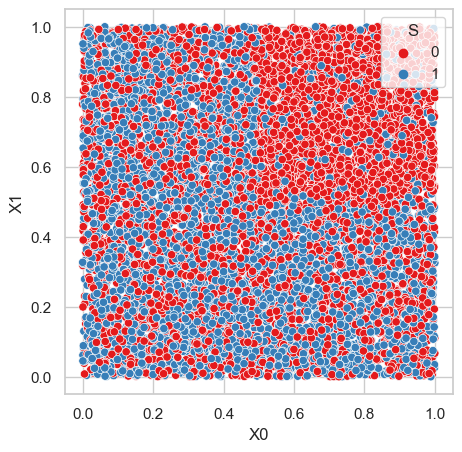

In [421]:
df, Y = strawman_edge.get_data(n=10000, seed=0)

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x="X0", y="X1", hue="S", data=df, palette="Set1")
fig.savefig("X0_vs_X1_hue_S.pdf", format="pdf", dpi=600)

atte_sim, atte_se_sim = est.estimate_sim(
    data=df, outcome="Yobs", treatment="T", sample="S"
)
atte_out_reg, atte_se_outreg = est.estimate_out_reg(
    data=df, outcome="Yobs", treatment="T", sample="S"
)
atte_dml, atte_se_dml = est.estimate_dml(
    data=df, outcome="Yobs", treatment="T", sample="S"
)
print((atte_sim, atte_se_sim))
print((atte_out_reg, atte_se_outreg))
print((atte_dml, atte_se_dml))
print((Y["Y1"].loc[df["S"] == 0] - Y["Y0"].loc[df["S"] == 0]).mean())

#### Section 1.1.1.a Plotting the Point Estimates and Interval Widths

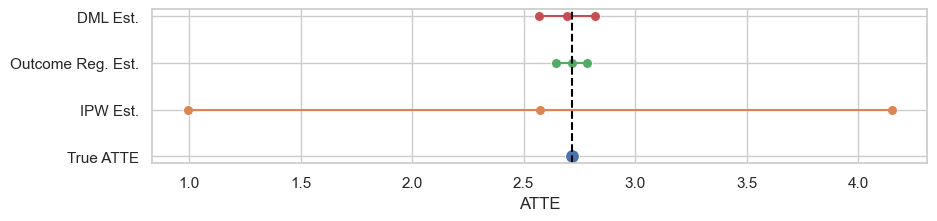

In [422]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 2))
sns.lineplot(
    x=[(Y["Y1"].loc[df["S"] == 0] - Y["Y0"].loc[df["S"] == 0]).mean()],
    y=[0],
    ax=ax,
)
sns.scatterplot(
    x=[(Y["Y1"].loc[df["S"] == 0] - Y["Y0"].loc[df["S"] == 0]).mean()],
    y=[0],
    ax=ax,
    s=100,
)
sns.lineplot(
    x=[atte_sim - (1.96 * atte_se_sim), atte_sim, atte_sim + (1.96 * atte_se_sim)],
    y=[1, 1, 1],
    ax=ax,
)
sns.scatterplot(
    x=[atte_sim - (1.96 * atte_se_sim), atte_sim, atte_sim + (1.96 * atte_se_sim)],
    y=[1, 1, 1],
    ax=ax,
    s=50,
)

sns.lineplot(
    x=[
        atte_out_reg - (1.96 * atte_se_outreg),
        atte_out_reg,
        atte_out_reg + (1.96 * atte_se_outreg),
    ],
    y=[2, 2, 2],
    ax=ax,
)
sns.scatterplot(
    x=[
        atte_out_reg - (1.96 * atte_se_outreg),
        atte_out_reg,
        atte_out_reg + (1.96 * atte_se_outreg),
    ],
    y=[2, 2, 2],
    ax=ax,
    s=50,
)

sns.lineplot(
    x=[
        atte_dml - (1.96 * atte_se_dml),
        atte_dml,
        atte_dml + (1.96 * atte_se_dml),
    ],
    y=[3, 3, 3],
    ax=ax,
)
sns.scatterplot(
    x=[
        atte_dml - (1.96 * atte_se_dml),
        atte_dml,
        atte_dml + (1.96 * atte_se_dml),
    ],
    y=[3, 3, 3],
    ax=ax,
    s=50,
)

plt.axvline(
    (Y["Y1"].loc[df["S"] == 0] - Y["Y0"].loc[df["S"] == 0]).mean(), c="black", ls="--"
)

plt.yticks([0, 1, 2, 3], ["True ATTE", "IPW Est.", "Outcome Reg. Est.", "DML Est."])
plt.xlabel("ATTE")
fig.savefig("ATTE_estimates.pdf", format="pdf", dpi=600)

### Section 1.1.2. Learning Optimal $w$ to improve precision of estimate
Here we primarly focus on Doubly Robust Estimator using different strategies to estimate $w(x)$

#### Section 1.1.2.a. Optimization via Linear $w(x)$

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.23096563005148485
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
(0.23096563005148485, 0.1433821184430667, 2.9134253675275708, 2.647334831681625)


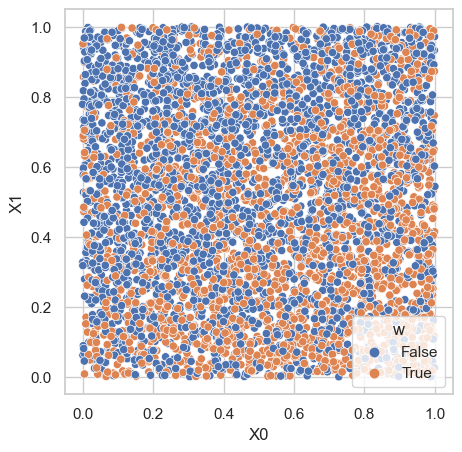

In [425]:
result, atte, se, atte_unpruned, se_unpruned, f, testing_data = learn.linear_opt(
    data=df, outcome="Yobs", treatment="T", sample="S"
)
print((se, se_unpruned, atte, atte_unpruned))

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=testing_data, x="X0", y="X1", hue="w")
fig.savefig("linear_opt_result.pdf", format="pdf", dpi=600)

#### Section 1.1.2.b. Optimization via Voronoi Sets using K-Means

(0.11919211420918746, 0.14508034690488394, 2.796204025472874, 2.831755070957463)


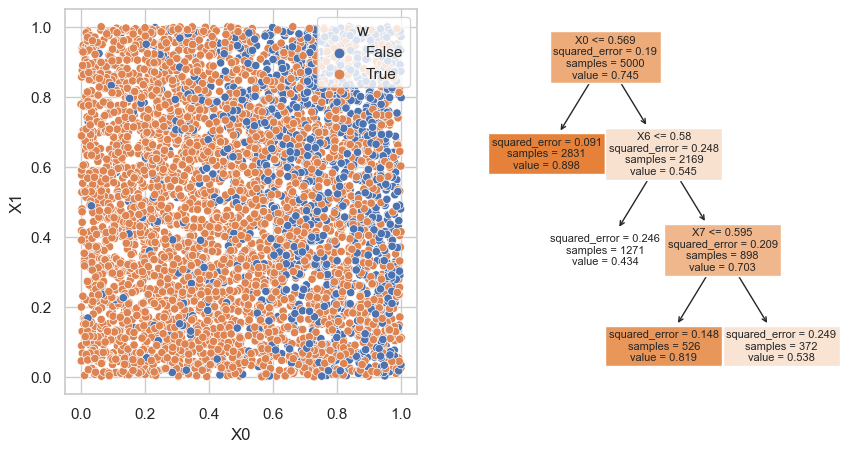

In [427]:
result, atte, se, atte_unpruned, se_unpruned, f, testing_data = learn.kmeans_opt(
    data=df, outcome="Yobs", treatment="T", sample="S", k=20
)
print((se, se_unpruned, atte, atte_unpruned))

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(data=testing_data, x="X0", y="X1", hue="w", ax=ax[0])

plot_tree = tree.plot_tree(
    f,
    feature_names=testing_data.drop(columns=["Yobs", "T", "S", "w"]).columns,
    ax=ax[1],
    filled=True,
)
fig.savefig("voronoi_kmeans_opt_result.pdf", format="pdf", dpi=600)

#### Section 1.1.2.c. Optimization via (Randomized) Tree $w(x)$

## Split Function Algorithm

The following algorithm outlines the process of the `split` function used in the context of a decision-making process.

```python
function split(split_feature, X, D, parent_loss, depth):
    # Determine the feature fj to split on based on the current depth
    fj = choose(split_feature, depth)

    # Check if this is a base case where we're reaching a leaf node
    if fj equals "leaf":
        # Calculate losses for class 0 and class 1
        losses = { loss(v, X, D) : for v in {0,1} }
        
        # Decide whether to exploit (choose best loss) or explore (random choice)
        w_exploit = argmin(losses)
        w_explore = random.binomial(1, 0.5)
        
        # Introduce randomness in exploration
        explore = random.binomial(1, 0.05)
        
        # Combine exploration and exploitation to decide the final weight
        w = (explore * w_explore) + ((1 - explore) * w_exploit)
        
        # Update the weight in both the global and local datasets
        D.loc[X.index, "w"] = w
        X.loc[X.index, "w"] = w
        
        # Return information about this leaf node
        return {"node": fj, "w": w, "objective": min(losses), "depth": depth}
        
    # Induction case
    else:
        # Calculate the midpoint for the selected feature fj
        cj = midpoint(X[fj])
        
        # Split the dataset into left and right based on the midpoint
        X_left = X.loc[X[fj] <= cj]
        X_right = X.loc[X[fj] > cj]
        
        # Calculate losses for left and right branches
        loss_left = { loss(v, X_left, D) : for v in {0,1} } 
        loss_right = { loss(v, X_right, D) : for v in {0,1} } 
        
        # Find the minimum losses for both left and right branches
        min_loss_left = min(loss_left)
        min_loss_right = min(loss_right)

        # Calculate new loss after the split
        new_loss = ( |X_left| * min_loss_left + |X_right| * min_loss_right) / |X|
        
        # Check if the new split reduces loss compared to parent node
        if new_loss <= parent_loss:
            # Find best actions to take for left and right branches
            w_left = argmin(loss_left)
            w_right = argmin(loss_right)

            # Update weights in both global and local datasets for left branch
            D.loc[X_left.index, "w"] = w_left
            X_left.loc[X_left.index, "w"] = w_left

            # Update weights in both global and local datasets for right branch
            D.loc[X_right.index, "w"] = w_right
            X_right.loc[X_right.index, "w"] = w_right
            
            # Recursively split the left and right branches
            return {
                "node": fj,
                "split": cj,
                "left_tree": split(split_feature, X_left, D, new_loss, depth + 1),
                "right_tree": split(split_feature, X_right, D, new_loss, depth + 1),
                "objective": sqrt(sum(D["vsq"] * D["w"]) / ((sum((1 - D["S"]) * D["w"]) ** 2)))),
                "depth": depth,
            }
        else:
            # If the new split doesn't improve loss, try a different split feature
            split_feature_updated = reduce_weight(fj, copy(split_feature, deep=True))
            return split(split_feature_updated, X, D, parent_loss, depth)


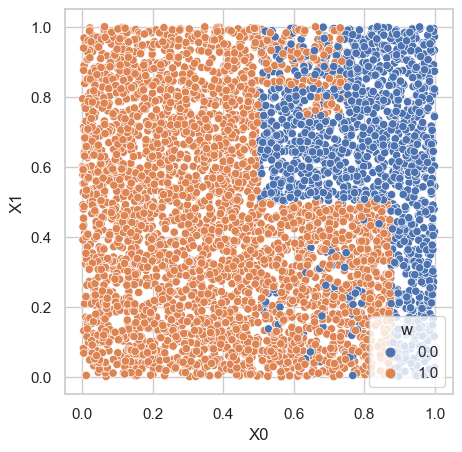

In [429]:
importlib.reload(learn)
D, w_tree, testing_data = learn.tree_opt(
    data=df, outcome="Yobs", treatment="T", sample="S", leaf_proba=0.25, seed=1
)

fig, ax = plt.subplots(ncols=1, figsize=(5, 5), sharex=True, sharey=True)
sns.scatterplot(x="X0", y="X1", data=D, hue="w")
fig.savefig("forest_opt_500trees_result.pdf", format="pdf", dpi=600)

#### Section 1.1.2.d. Optimization via (Randomized) Forest $w(x)$ 
Trees with objective worse than baseline are pruned

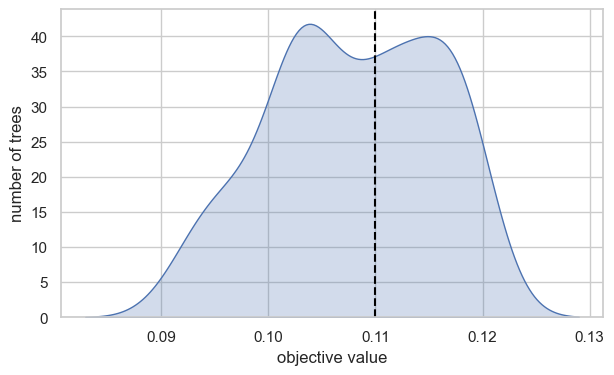

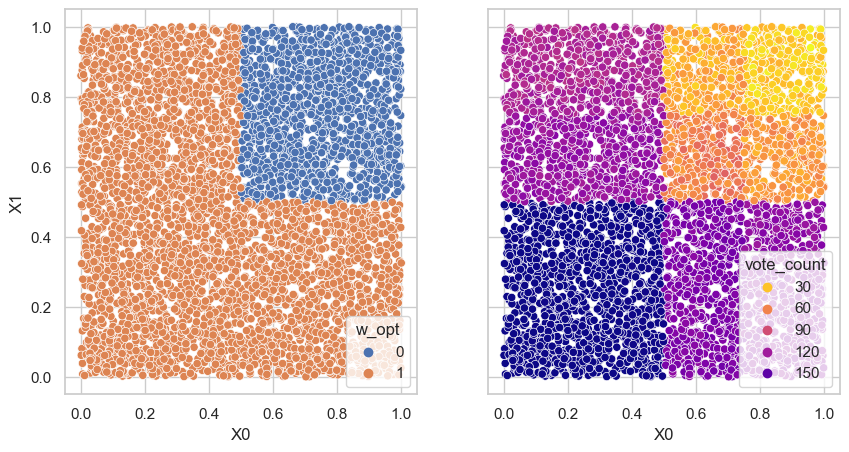

In [430]:
importlib.reload(learn)
D_rash, D_forest, w_forest, rashomon_set, testing_data = learn.forest_opt(
    data=df,
    outcome="Yobs",
    treatment="T",
    sample="S",
    leaf_proba=1,
    num_trees=500,
    vote_threshold=1 / 2,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((np.sum((1 - D_forest["S"])) ** 2)))

fig, ax = plt.subplots(nrows=1, figsize=(7, 4))
# sns.histplot(
#     D_forest[[col for col in D_forest.columns if "w_tree" in col]].mean(), ax=ax[0]
# )

sns.kdeplot(
    [
        w_forest[i]["local objective"]
        for i in range(len(w_forest))
        if w_forest[i]["local objective"] < 0.12
    ],
    ax=ax,
    fill=True,
)
ax.axvline(0.11, c="black", ls="--")
ax.set_xlabel("objective value")
ax.set_ylabel("number of trees")

# D_w_rash = D_forest[["w_tree_%d" % (i) for i in rashomon_set]]
# D_forest["w opt"] = (D_w_rash.mean(axis=1) > (2 / 3)).astype(int)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
sns.scatterplot(x="X0", y="X1", hue="w_opt", data=D_rash, ax=ax[0])
sns.scatterplot(
    x="X0", y="X1", hue="vote_count", data=D_rash, ax=ax[1], palette="plasma_r"
)
fig.savefig("forest_opt_500trees_result.pdf", format="pdf", dpi=600)

## Section 1.2. All Linear DGP
$Y(0) = \beta_0^T X + \epsilon$ \
$Y(1) = Y(0) + \beta_1^T X + \epsilon$ \
$P(S=1 \mid X ) = expit( \alpha_0^T X )$

(array([-4.18201994,  1.42942861, -0.95389448, ..., -0.6601245 ,
        0.00616464, -2.52296175]), array([0.01503804, 0.80681227, 0.27810228, ..., 0.34071164, 0.50154116,
       0.07426407]))


coef. X0  coef. X1  coef. X2  coef. X3  coef. X4  coef. X5  \
selection           0.0      -1.0       0.0       1.0      1.00       0.0   
heterogeneity       4.0       2.0       1.0       0.5      0.25       0.0   

               coef. X6  coef. X7  coef. X8  coef. X9  coef. X10  coef. X11  \
selection           0.0      -1.0       1.0       1.0        1.0       -1.0   
heterogeneity       0.0       0.0       0.0       0.0        0.0        0.0   

               coef. X12  coef. X13  coef. X14  coef. X15  coef. X16  \
selection            0.0        0.0        0.0        1.0        0.0   
heterogeneity        0.0        0.0        0.0        0.0        0.0   

               coef. X17  coef. X18  coef. X19  
selection            0.0        0.0       -1.0  
heterogeneity        0.0        0.0        0.0

<Axes: xlabel='X1', ylabel='X3'>

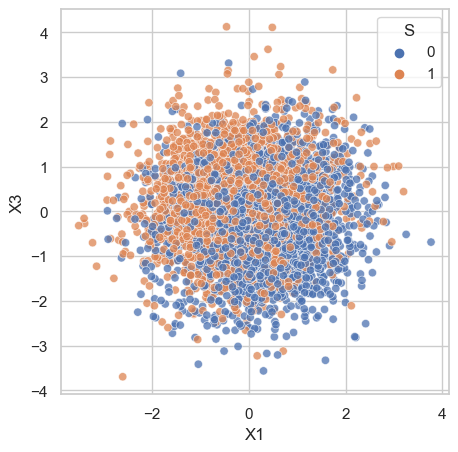

In [659]:
importlib.reload(all_linear)
df, Y, coef = all_linear.get_data(n=5000, seed=1)

display(pd.DataFrame(coef, index=["coef. X%d" % (i) for i in range(20)]).T)

#### plot scatter plot of X0 vs X1 and mark the region that is undersampled in experiment (truth)
sns.set(style="whitegrid")
#### plot scatter plot of X0 vs X1 and mark the points in the region that is highlighted as undersampled in experiment (est)
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x="X1", y="X3", hue="S", data=df, alpha=0.75, ax=ax)


   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 4.891670E-02    MAXCV = 0.000000E+00
   X = 4.428971E-01  -7.765580E+00   2.046544E+00   6.939425E+00   4.846292E+00
       2.270383E+00   1.525710E-01  -3.967634E+00   6.853539E+00   7.181015E+00
       4.838562E+00  -6.210431E+00  -2.234459E-02  -1.548227E+00   1.770341E+00
       4.675397E+00  -8.570153E-01  -3.848140E-01   4.561756E-02  -7.158627E+00
(0.04664241613956014, 0.06308710605475129, -0.04460958667727272, 0.29650986595182005)
[ 0.44289706 -7.76558047  2.04654375  6.93942509  4.8462918   2.27038331
  0.15257098 -3.96763388  6.85353865  7.1810152   4.83856159 -6.21043067
 -0.02234459 -1.54822746  1.77034064  4.67539721 -0.85701532 -0.38481399
  0.04561756 -7.15862747]


[Text(0.6666666666666666, 0.875, 'X1 <= 0.019\nsquared_error = 0.25\nsamples = 2500\nvalue = 0.488'),
 Text(0.5, 0.625, 'X9 <= 0.535\nsquared_error = 0.231\nsamples = 1259\nvalue = 0.639'),
 Text(0.3333333333333333, 0.375, 'X4 <= 0.202\nsquared_error = 0.248\nsamples = 869\nvalue = 0.543'),
 Text(0.16666666666666666, 0.125, 'squared_error = 0.243\nsamples = 508\nvalue = 0.415'),
 Text(0.5, 0.125, 'squared_error = 0.2\nsamples = 361\nvalue = 0.723'),
 Text(0.6666666666666666, 0.375, 'squared_error = 0.127\nsamples = 390\nvalue = 0.851'),
 Text(0.8333333333333334, 0.625, 'squared_error = 0.223\nsamples = 1241\nvalue = 0.335')]

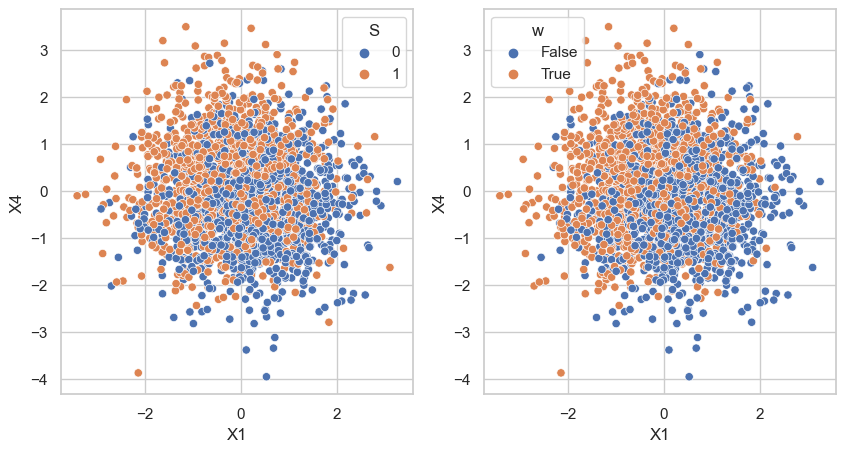

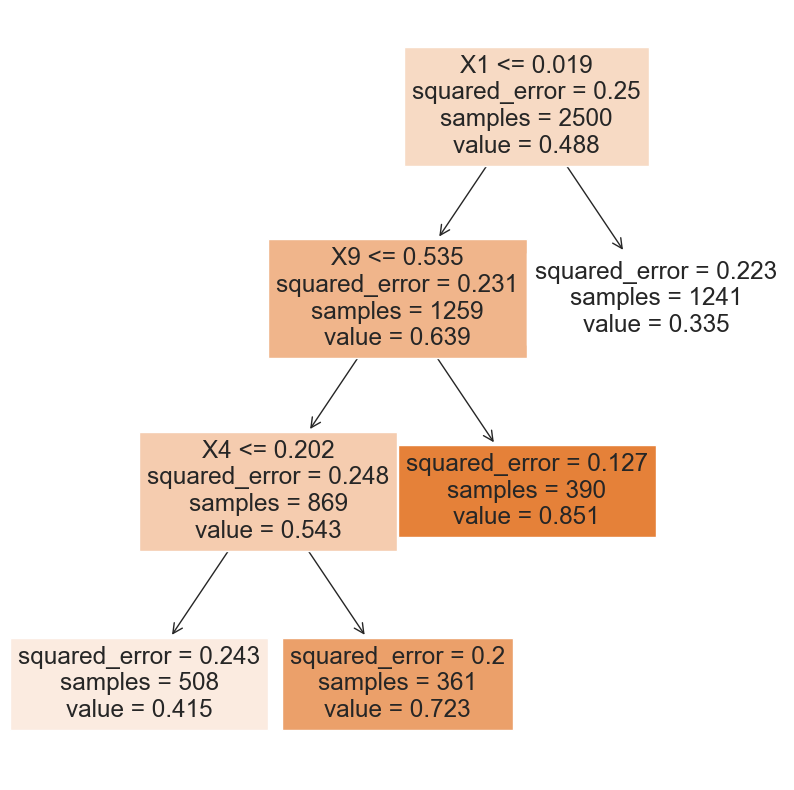

In [664]:
importlib.reload(learn)
result, atte, se, atte_unpruned, se_unpruned, f, testing_data = learn.linear_opt(
    data=df,
    outcome="Yobs",
    treatment="T",
    sample="S",
)
print((se, se_unpruned, atte, atte_unpruned))
print(result.x)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(data=testing_data, x="X1", y="X4", hue="w", ax=ax[1])
sns.scatterplot(data=testing_data, x="X1", y="X4", hue="S", ax=ax[0])
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
tree.plot_tree(
    f,
    ax=ax,
    feature_names=testing_data.drop(columns=["Yobs", "T", "S"]).columns,
    filled=True,
)
# fig.savefig("linear_opt_result.pdf", format="pdf", dpi=600)

leaf    0.500000
X0      0.005019
X1      0.051345
X2      0.001970
X3      0.041225
X4      0.045590
X5      0.016642
X6      0.001209
X7      0.038954
X8      0.053020
X9      0.040233
X10     0.033038
X11     0.039860
X12     0.013977
X13     0.000458
X14     0.003758
X15     0.029003
X16     0.007700
X17     0.008903
X18     0.021372
X19     0.046725
dtype: float64


[Text(0.5625, 0.9, 'X1 <= 1.588\ngini = 0.23\nsamples = 2500\nvalue = [331, 2169]'),
 Text(0.5, 0.7, 'X1 <= -1.762\ngini = 0.149\nsamples = 2361\nvalue = [192, 2169]'),
 Text(0.25, 0.5, 'X2 <= 0.355\ngini = 0.497\nsamples = 96\nvalue = [44, 52]'),
 Text(0.125, 0.3, 'X19 <= -0.087\ngini = 0.463\nsamples = 55\nvalue = [35, 20]'),
 Text(0.0625, 0.1, 'gini = 0.408\nsamples = 21\nvalue = [6, 15]'),
 Text(0.1875, 0.1, 'gini = 0.251\nsamples = 34\nvalue = [29, 5]'),
 Text(0.375, 0.3, 'X7 <= 1.087\ngini = 0.343\nsamples = 41\nvalue = [9, 32]'),
 Text(0.3125, 0.1, 'gini = 0.234\nsamples = 37\nvalue = [5, 32]'),
 Text(0.4375, 0.1, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.75, 0.5, 'X7 <= 1.245\ngini = 0.122\nsamples = 2265\nvalue = [148, 2117]'),
 Text(0.625, 0.3, 'X1 <= 1.418\ngini = 0.095\nsamples = 2014\nvalue = [101, 1913]'),
 Text(0.5625, 0.1, 'gini = 0.086\nsamples = 1964\nvalue = [88, 1876]'),
 Text(0.6875, 0.1, 'gini = 0.385\nsamples = 50\nvalue = [13, 37]'),
 Text(0.875, 0.3, 

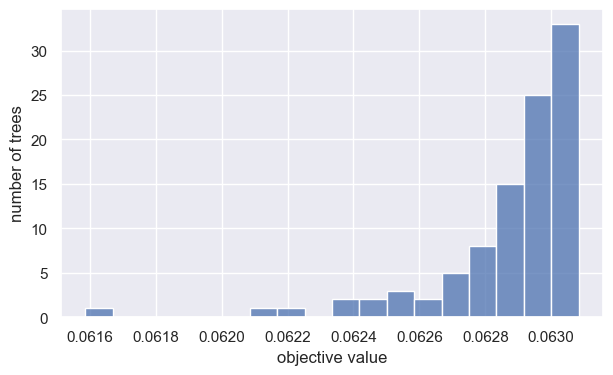

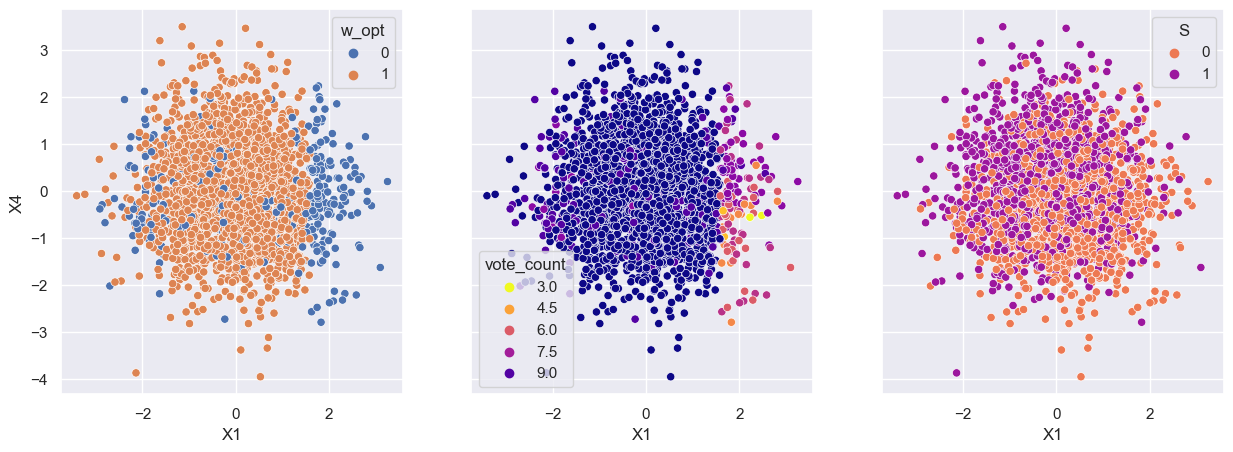

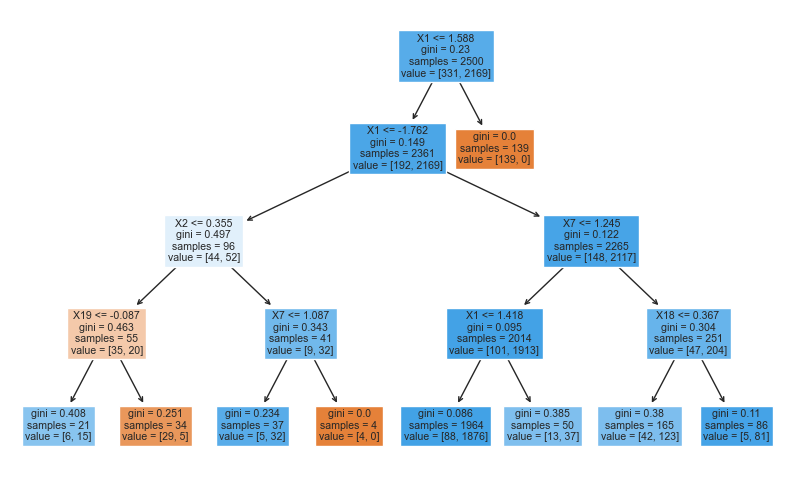

In [675]:
importlib.reload(learn)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=df,
    outcome="Yobs",
    treatment="T",
    sample="S",
    leaf_proba=1,
    num_trees=1000,
    vote_threshold=9 / 10,
    top_k_trees=True,
    k=10,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0] ** 2)))

fig, ax = plt.subplots(nrows=1, figsize=(7, 4))
sns.histplot(
    [
        w_forest[i]["local objective"]
        for i in range(len(w_forest))
        if w_forest[i]["local objective"] < baseline_loss
    ],
    ax=ax,
    fill=True,
)
ax.set_xlabel("objective value")
ax.set_ylabel("number of trees")


fig, ax = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)
sns.scatterplot(x="X1", y="X4", hue="w_opt", data=D_rash, ax=ax[0])
sns.scatterplot(
    x="X1", y="X4", hue="vote_count", data=D_rash, ax=ax[1], palette="plasma_r"
)
sns.scatterplot(x="X1", y="X4", hue="S", data=D_rash, ax=ax[2], palette="plasma_r")

sns.set(font_scale=1)
fig, ax = plt.subplots(ncols=1, figsize=(10, 6), sharex=True, sharey=True)
tree.plot_tree(
    f,
    ax=ax,
    feature_names=testing_data.drop(columns=["Yobs", "T", "S"]).columns,
    filled=True,
)
# fig.savefig("forest_opt_500trees_result_all_linear.pdf", format="pdf", dpi=600)

## Section 1.3. Strawman (Hard Mode) Example with under represented samples in the middle
$P(S=1 \mid X) = expit( - 3\left((X_0 > 0.4) (X_0 < 0.6) (X_1 > 0.4) (X_1 < 0.6)\right) )$ \
$Y(0) = 10 sin(\pi X_0 X_1) + 20 (X_2 - 0.5)^2 + 10 X_3 + 5 X_4 + \epsilon$ \
$Y(1) = Y(0) + log(Y(0) + 1)$

<Axes: xlabel='X0', ylabel='X1'>

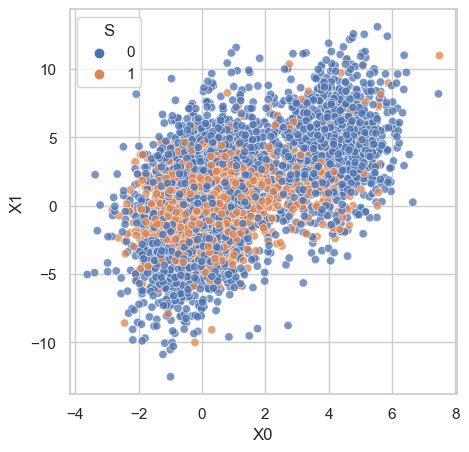

In [769]:
importlib.reload(strawman_center)
df, Y = strawman_center.get_data(n=5000, seed=0)

#### plot scatter plot of X0 vs X1 and mark the region that is undersampled in experiment (truth)
sns.set(style="whitegrid")

#### plot scatter plot of X0 vs X1 and mark the points in the region that is highlighted as undersampled in experiment (est)
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x="X0", y="X1", hue="S", data=df, alpha=0.75, ax=ax)

In [770]:
v, vsq, pi, pi_m, mu_1_m, mu_0_m, e_m, testing_data = learn.estimate_dml(
    data=df, outcome="Yobs", treatment="T", sample="S"
)

In [771]:
X = testing_data.drop(columns=["Yobs", "T", "S"])
S = testing_data["S"]
Spred = pi_m.predict_proba(X)[:, 1]

<Axes: xlabel='X0', ylabel='X1'>

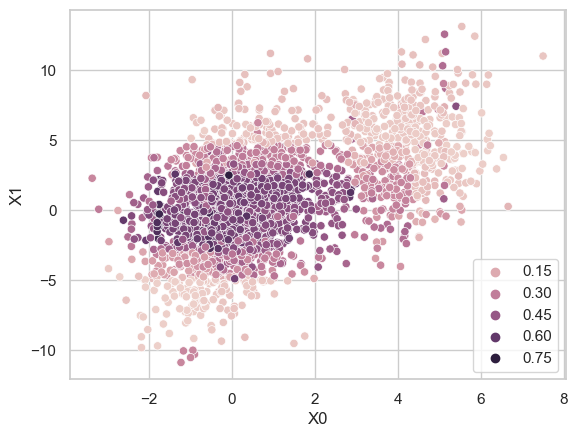

In [772]:
sns.scatterplot(x=X["X0"], y=X["X1"], hue=Spred)

<Axes: xlabel='X0', ylabel='X1'>

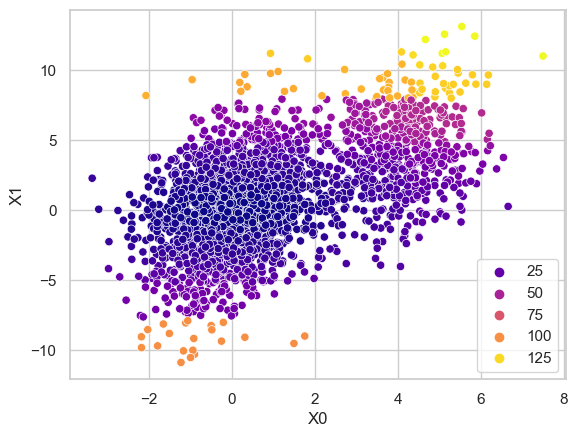

In [773]:
sns.scatterplot(x=X["X0"], y=X["X1"], hue=mu_1_m.predict(X), palette="plasma")

leaf    0.500000
X0      0.486477
X1      0.013523
dtype: float64
1.729235781121555


[Text(0.5, 0.75, 'X0 <= 2.051\ngini = 0.381\nsamples = 2500\nvalue = [640, 1860]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 1860\nvalue = [0, 1860]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 640\nvalue = [640, 0]')]

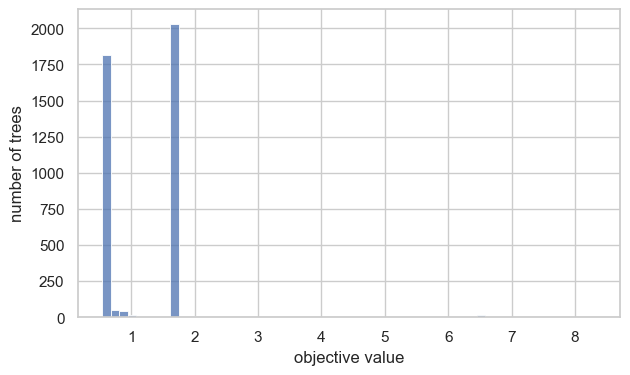

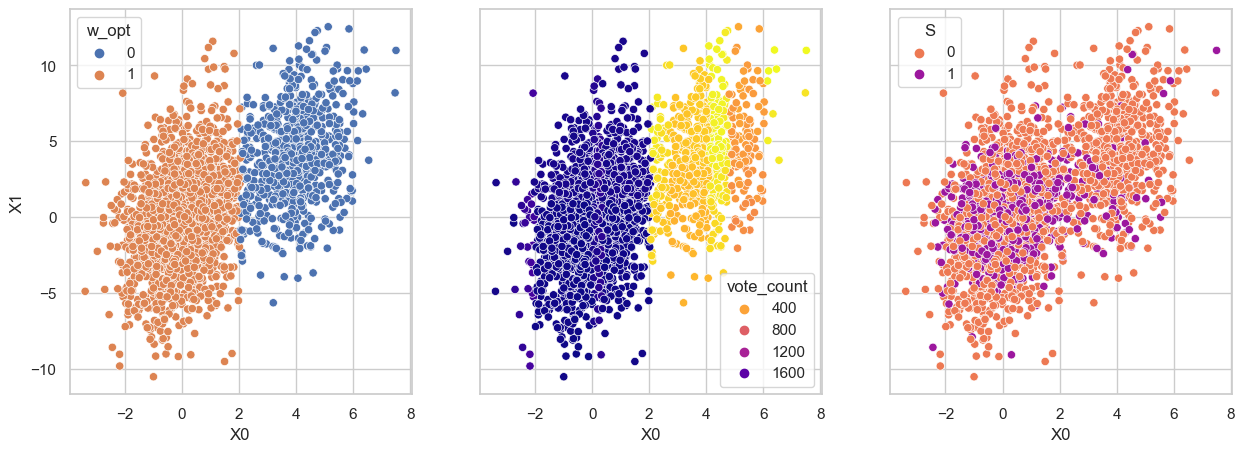

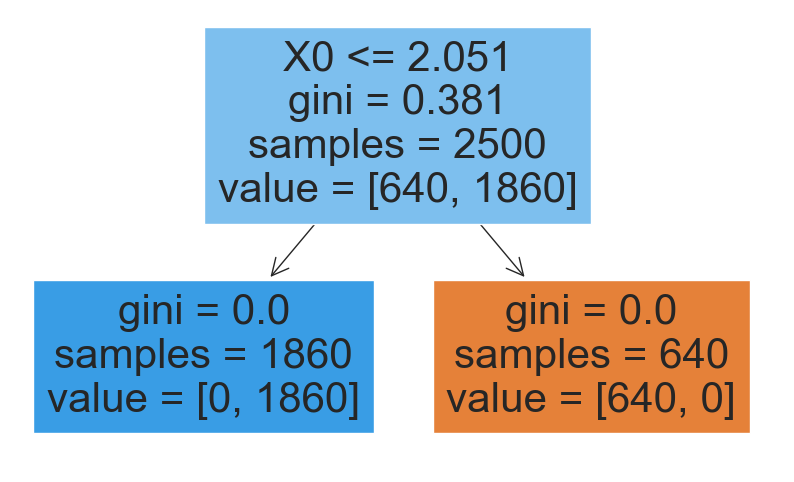

In [774]:
importlib.reload(learn)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=df,
    outcome="Yobs",
    treatment="T",
    sample="S",
    leaf_proba=1,
    num_trees=4000,
    vote_threshold=1 / 2,
    explore_proba=0.5,
    feature_est="Non-Linear",
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0]) ** 2))
print(baseline_loss)
fig, ax = plt.subplots(nrows=1, figsize=(7, 4))
# sns.histplot(
#     D_forest[[col for col in D_forest.columns if "w_tree" in col]].mean(), ax=ax[0]
# )

sns.histplot(
    [
        w_forest[i]["local objective"]
        for i in range(len(w_forest))
        if w_forest[i]["local objective"]
    ],
    ax=ax,
    fill=True,
)
ax.set_xlabel("objective value")
ax.set_ylabel("number of trees")


# rashomon_set = [
#     i for i in range(len(w_forest)) if w_forest[i]["local objective"] < baseline_loss
# ]
# D_w_rash = D_forest[["w_tree_%d" % (i) for i in rashomon_set]]
# D_rash["w_opt"] = (D_w_rash.mean(axis=1) > (3 / 4)).astype(int)
# D_rash["vote_count"] = D_w_rash.sum(axis=1)


fig, ax = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)
sns.scatterplot(x="X0", y="X1", hue="w_opt", data=D_rash, ax=ax[0])
sns.scatterplot(
    x="X0", y="X1", hue="vote_count", data=D_rash, ax=ax[1], palette="plasma_r"
)
sns.scatterplot(x="X0", y="X1", hue="S", data=D_rash, ax=ax[2], palette="plasma_r")

sns.set(font_scale=1)
fig, ax = plt.subplots(ncols=1, figsize=(10, 6), sharex=True, sharey=True)
tree.plot_tree(
    f,
    ax=ax,
    feature_names=testing_data.drop(columns=["Yobs", "T", "S"]).columns,
    filled=True,
)
# fig.savefig("forest_opt_500trees_result_all_linear.pdf", format="pdf", dpi=600)

(0.7743474211252679, 1.4354830486438093, 14.288745517989774, 17.517390010518245)


[Text(0.5, 0.8333333333333334, 'X1 <= 8.666\ngini = 0.035\nsamples = 2500\nvalue = [45, 2455]'),
 Text(0.25, 0.5, 'X1 <= 8.138\ngini = 0.005\nsamples = 2456\nvalue = [6, 2450]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.0\nsamples = 2437\nvalue = [0, 2437]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.432\nsamples = 19\nvalue = [6, 13]'),
 Text(0.75, 0.5, 'X0 <= 3.005\ngini = 0.201\nsamples = 44\nvalue = [39, 5]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.278\nsamples = 6\nvalue = [1, 5]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.0\nsamples = 38\nvalue = [38, 0]')]

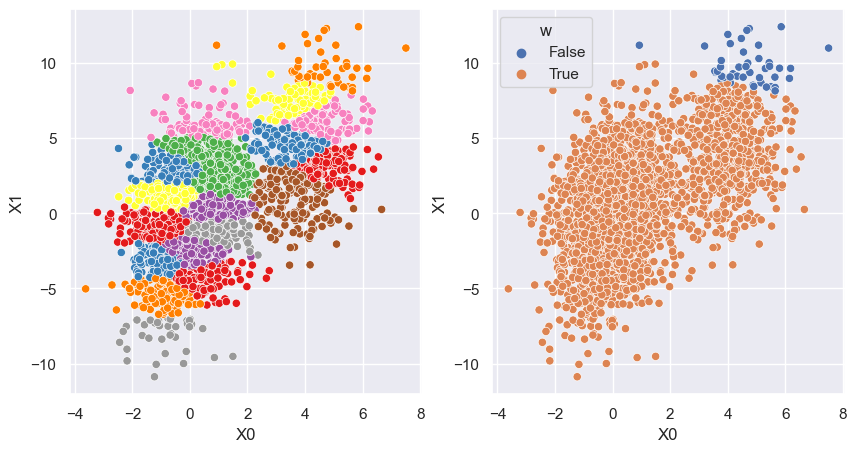

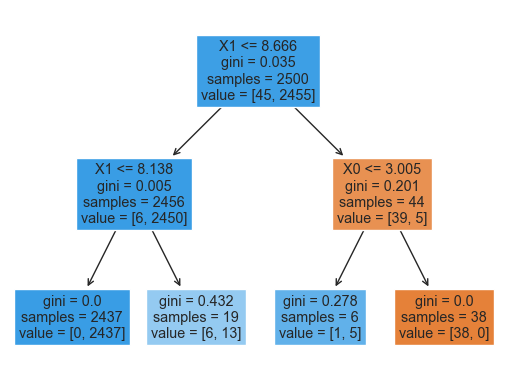

In [775]:
importlib.reload(learn)
np.random.seed(0)
D_labels, atte, se, atte_unpruned, se_unpruned, f, testing_data = learn.kmeans_opt(
    data=df, outcome="Yobs", treatment="T", sample="S", k=20
)
print((se, se_unpruned, atte, atte_unpruned))

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(
    data=D_labels, x="X0", y="X1", hue="group", ax=ax[0], palette="Set1", legend=False
)
sns.scatterplot(data=D_labels, x="X0", y="X1", hue="w", ax=ax[1])

f = learn.characterize_tree(
    X=testing_data.drop(columns=["Yobs", "T", "S", "w"]),
    w=D_labels["w"].astype(int),
    max_depth=2,
)

fig, ax = plt.subplots()
tree.plot_tree(
    f,
    feature_names=testing_data.drop(columns=["Yobs", "T", "S", "w"]).columns,
    filled=True,
)

# plot_tree = tree.plot_tree(
#     f,
#     feature_names=testing_data.drop(columns=["Yobs", "T", "S", "w"]).columns,
#     ax=ax[1],
#     filled=True,
# )
# fig.savefig("voronoi_kmeans_opt_result.pdf", format="pdf", dpi=600)

# Section 2. LaLonde Analysis

In [4]:
nsw = pd.read_stata("http://www.nber.org/~rdehejia/data/nsw.dta")
psid_control = pd.read_stata("http://www.nber.org/~rdehejia/data/psid_controls.dta")

np.random.seed(0)
ATE_exp = (
    nsw.loc[nsw["treat"] == 1, "re78"].mean()
    - nsw.loc[nsw["treat"] == 0, "re78"].mean()
)
print("ATE Experimental: " + str(ATE_exp))
print("E[Y(1) | S=1]: " + str(nsw.loc[nsw["treat"] == 1, "re78"].mean()))
print("E[Y(0) | S=1]: " + str(nsw.loc[nsw["treat"] == 0, "re78"].mean()))
print(
    "E[ Y | T=0, S=0]: "
    + str(psid_control.loc[psid_control["treat"] == 0, "re78"].mean())
)

ATE Experimental: 886.3037
E[Y(1) | S=1]: 5976.352
E[Y(0) | S=1]: 5090.0483
E[ Y | T=0, S=0]: 21553.922


In [8]:
df_lalonde = nsw.append(psid_control.drop(columns=["re74"]))
df_lalonde["data_id"] = (df_lalonde["data_id"] == "Lalonde Sample").astype(int)

leaf         5.000000e-01
age          2.615500e-03
education    5.062524e-03
black        2.009227e-01
hispanic     8.353152e-02
married      1.503971e-01
nodegree     5.747042e-02
re75         2.340920e-07
dtype: float64
1209.4843213393683


Text(0, 0.5, 'number of trees')

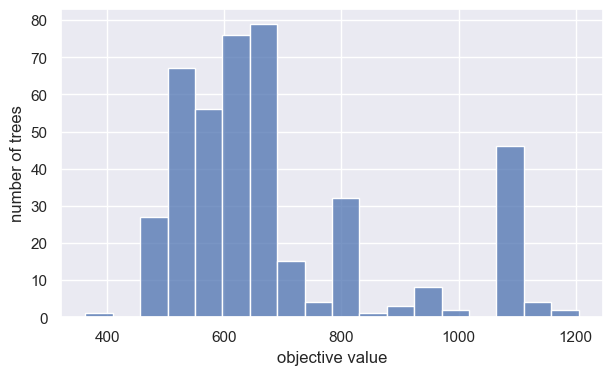

In [20]:
importlib.reload(learn)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=df_lalonde,
    outcome="re78",
    treatment="treat",
    sample="data_id",
    leaf_proba=1,
    num_trees=1000,
    vote_threshold=2 / 3,
    # top_k_trees=True,
    # k=10,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0] ** 2)))
print(baseline_loss)

fig, ax = plt.subplots(nrows=1, figsize=(7, 4))
sns.histplot(
    [
        w_forest[i]["local objective"]
        for i in range(len(w_forest))
        if w_forest[i]["local objective"] < baseline_loss
    ],
    ax=ax,
    fill=True,
)
ax.set_xlabel("objective value")
ax.set_ylabel("number of trees")

[Text(0.625, 0.875, 'black <= 0.5\ngini = 0.308\nsamples = 1606\nvalue = [1300, 306]'),
 Text(0.5, 0.625, 'nodegree <= 0.5\ngini = 0.424\nsamples = 1003\nvalue = [697, 306]'),
 Text(0.25, 0.375, 'married <= 0.5\ngini = 0.196\nsamples = 736\nvalue = [655, 81]'),
 Text(0.125, 0.125, 'gini = 0.349\nsamples = 102\nvalue = [23, 79]'),
 Text(0.375, 0.125, 'gini = 0.006\nsamples = 634\nvalue = [632, 2]'),
 Text(0.75, 0.375, 'hispanic <= 0.5\ngini = 0.265\nsamples = 267\nvalue = [42, 225]'),
 Text(0.625, 0.125, 'gini = 0.062\nsamples = 217\nvalue = [7, 210]'),
 Text(0.875, 0.125, 'gini = 0.42\nsamples = 50\nvalue = [35, 15]'),
 Text(0.75, 0.625, 'gini = 0.0\nsamples = 603\nvalue = [603, 0]')]

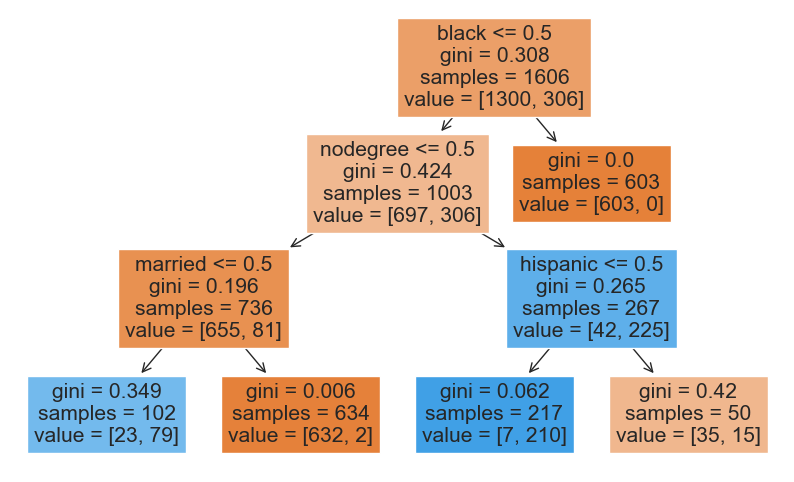

In [21]:
sns.set(font_scale=1)
fig, ax = plt.subplots(ncols=1, figsize=(10, 6), sharex=True, sharey=True)
tree.plot_tree(
    f,
    ax=ax,
    feature_names=testing_data.drop(columns=["re78", "treat", "data_id"]).columns,
    filled=True,
)
fig.savefig("lalonde_forest.pdf", format="pdf", dpi=600)

Underrepresented Population in Lalonde Study - Male sample (compared to PSID):
* White males without degree -- primary group
* Non-black unmarried males with degree -- secondary group

In [25]:
selection_model = lm.LogisticRegressionCV().fit(
    testing_data.drop(columns=["re78", "treat", "data_id"]), testing_data["data_id"]
)

In [29]:
pd.DataFrame(
    selection_model.coef_,
    columns=testing_data.drop(columns=["re78", "treat", "data_id"]).columns,
)

age  education     black  hispanic   married  nodegree     re75
0 -0.126528  -0.060235  1.851037  0.959437 -2.138419  1.164105 -0.00016